In [1]:
!pip install gdown

In [2]:
import gdown
import tarfile
import os

url = 'https://drive.usercontent.google.com/download?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download&authuser=0&confirm=t&uuid=60b63e1a-f494-4f24-bdb1-b55131562a39&at=APZUnTVF0wI3FBlvrHXL3r-PlZjg:1704103333738'
output = 'train.tar'
if not os.path.exists(output):
  print('Downloading dataset')
  gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.usercontent.google.com/download?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download&authuser=0&confirm=t&uuid=60b63e1a-f494-4f24-bdb1-b55131562a39&at=APZUnTVF0wI3FBlvrHXL3r-PlZjg:1704103333738
To: /content/train.tar
100%|██████████| 126M/126M [00:01<00:00, 67.8MB/s]


In [3]:
extraction_path='./data/miniImageNet'
if not os.path.exists(extraction_path):
  with tarfile.open(output) as tar:
      tar.extractall(path=extraction_path)

In [4]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import os
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import time
from tempfile import TemporaryDirectory
import random
import numpy as np
from torchvision.io import read_image
import torchvision.transforms.functional as F
import time

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [6]:
T_0 = 1000 # Number of iterations for the first restart.
LEARNING_RATE=0.001 # 0.0001
WEIGHT_DECAY=0.0005 # 0.000001
NUM_EPOCHS=1
BATCH_SIZE=32
MOMENTUM=0.9
num_of_classes = 64
STEP_SIZE=7
GAMMA=0.01

In [7]:
SHUFFLE=True
WORKERS=2
num_images = 8

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        # transforms.RandomResizedCrop(84),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(3,sigma=(0.5, 2.0)),
        transforms.RandomRotation(degrees=(0, 30)),
        transforms.RandomAdjustSharpness(0.25),
        transforms.RandomAutocontrast(0.25),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
    ]),
    'tune': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAdjustSharpness(0.25),
        transforms.RandomAutocontrast(0.25),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}


def GetDataLoaders(data_dir, batch_size=4, shuffle=True, num_workers=4, validation_split=0.2, test_split=0.1):
    original_train_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
    # print(dir(original_train_dataset))

    # Calculate the number of samples for each split
    num_samples = len(original_train_dataset)
    num_val = int(validation_split * num_samples)
    num_test = int(test_split * num_samples)
    num_train = num_samples - num_val - num_test

    # Split the dataset into train, validation, and test sets
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(original_train_dataset, [num_train, num_val, num_test])

    # Create data loaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    dataset_sizes = {
        'train': num_train,
        'val': num_val,
        'test': num_test
    }
    class_names = original_train_dataset.classes

    return dataloaders, class_names, dataset_sizes

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_dir = './data/miniImageNet/train'
dataloaders, class_names, dataset_sizes  = GetDataLoaders(data_dir, BATCH_SIZE, SHUFFLE, num_workers=WORKERS)

train_loader = dataloaders['train']
validation_loader = dataloaders['val']
test_loader = dataloaders['test']

In [10]:
def SmallGetDataLoaders(data_dir, batch_size=4, shuffle=True, num_workers=4, validation_split=0.2, test_split=0.1):
    original_train_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
    return original_train_dataset

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

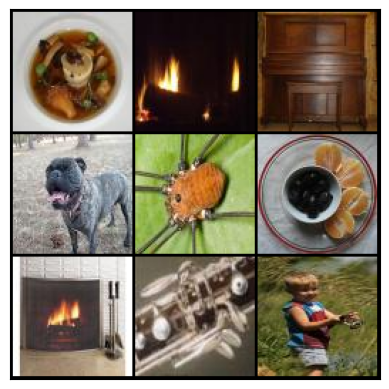

In [11]:
dataset  = SmallGetDataLoaders(data_dir, BATCH_SIZE, SHUFFLE, num_workers=WORKERS)

x = 9  # Set the number of items you want to pick
random_samples = random.sample(dataset.samples, x)
img_list = []
img = None
for i in range(len(random_samples)):
    img_path = random_samples[i][0]
    img = read_image(img_path)
    img_list.append(img)
grid = torchvision.utils.make_grid(img_list, nrow=3, scale_each=True)
show(grid)

In [12]:
dataloaders, class_names, dataset_sizes  = GetDataLoaders(data_dir, BATCH_SIZE, SHUFFLE, num_workers=WORKERS)

train_loader = dataloaders['train']
validation_loader = dataloaders['val']
test_loader = dataloaders['test']

In [13]:

def eval_func(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    else:
        print("No Cude")
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images)
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# references: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, dataset_sizes):
    since = time.time()
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
    else:
        print("No Cude")
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        train_losses = [] # Log the training loss
        train_avg_losses = [] # Log the training loss
        val_losses = []
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                correct = 0.0 # used to accumulate number of correctly recognized images
                num_images = 0.0 # used to accumulate number of images
                epoch_loss = 0.0

                # Iterate over data.
                for i_batch, (images, labels) in enumerate(dataloaders[phase]):
                    if use_cuda:
                        images = images.cuda()
                        labels = labels.cuda()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            epoch_loss += loss.item()

                    # statistics
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels)
                if phase == 'train':
                    # scheduler.step()
                    train_losses.append(loss.item())
                    train_avg_losses.append(epoch_loss / dataset_sizes[phase])
                else:
                    val_losses.append(loss.item())

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        plt.title('Train and Validation losses')
        plt.plot(train_losses, label='training losses')
        plt.plot(val_losses, label='validation losses')
        plt.legend()
        plt.show()

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [14]:
criterion = torch.nn.CrossEntropyLoss()

In [15]:
from torchvision.models import resnet18, ResNet18_Weights
class Restnet18_WithoutTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        weights=ResNet18_Weights.DEFAULT
        self.model = resnet18(weights=weights, progress=False)
        # self.transform = weights.transforms(antialias=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x = self.transform(x)
        return self.model(x)

In [16]:
net = Restnet18_WithoutTransformer(num_of_classes).to(device)
for p in net.parameters():
    p.requires_grad = True
net.train()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Restnet18_WithTransformer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [ ]:
optimizer = torch.optim.SGD(params= net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print('Please wait patiently, it may take some seconds...')
best_model = train_model(net, dataloaders, criterion, optimizer, scheduler, NUM_EPOCHS, dataset_sizes)
save_path = 'best_model_Resnet18.pth'
torch.save(best_model.state_dict(), save_path)

eval_acc = eval_func(best_model, dataloaders['test'])
print('')
print('Accuracy on testing data: %f' % eval_acc)

Please wait patiently, it may take some seconds...
Epoch 0/0
----------


In [ ]:
def visualize_models(model, dataloaders, num_images, class_names):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
loadModel = Restnet18_WithTransformer(num_of_classes).to(device)
save_path = 'best_model_Resnet18.pth'
loadModel.load_state_dict(torch.load(save_path))
visualize_models(loadModel, dataloaders, num_images, class_names)